In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns

In [2]:
df2 = pd.read_csv('7_dwarfs_train.csv')

In [3]:
df3 = pd.read_csv('alien_saucers.csv')

In [4]:
df4 = pd.read_csv('dinosaur.csv')

In [5]:
df5 = pd.read_csv('expedition_everest.csv')

In [6]:
df6 = pd.read_csv('flight_of_passage.csv')

In [7]:
df7 = pd.read_csv('kilimanjaro_safaris.csv')

In [8]:
df8 = pd.read_csv('navi_river.csv')

In [9]:
df9 = pd.read_csv('pirates_of_caribbean.csv')

In [10]:
df10 = pd.read_csv('rock_n_rollercoaster.csv')

In [11]:
df11 = pd.read_csv('slinky_dog.csv')

In [12]:
df12 = pd.read_csv('soarin.csv')

In [13]:
df13 = pd.read_csv('spaceship_earth.csv')

In [14]:
df14 = pd.read_csv('splash_mountain.csv')

In [15]:
df15 = pd.read_csv('toy_story_mania.csv')

In [16]:
df = pd.concat([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15])

In [17]:
df

,date,datetime,SACTMIN,SPOSTMIN
0,01/01/2015,2015-01-01 07:51:12,NaN,45.0
1,01/01/2015,2015-01-01 08:02:13,NaN,60.0
2,01/01/2015,2015-01-01 08:05:30,54.0,NaN
3,01/01/2015,2015-01-01 08:09:12,NaN,60.0
4,01/01/2015,2015-01-01 08:16:12,NaN,60.0
...,...,...,...,...
217122,12/31/2019,2019-12-31 23:30:02,NaN,20.0
217123,12/31/2019,2019-12-31 23:37:02,NaN,15.0
217124,12/31/2019,2019-12-31 23:44:02,NaN,15.0
217125,12/31/2019,2019-12-31 23:51:02,NaN,5.0


In [18]:
df['SPOSTMIN'] = df['SPOSTMIN'].fillna((df['SPOSTMIN'].ffill()))
df = df.drop(columns = {'date'})

In [19]:
df

,datetime,SACTMIN,SPOSTMIN
0,2015-01-01 07:51:12,NaN,45.0
1,2015-01-01 08:02:13,NaN,60.0
2,2015-01-01 08:05:30,54.0,60.0
3,2015-01-01 08:09:12,NaN,60.0
4,2015-01-01 08:16:12,NaN,60.0
...,...,...,...
217122,2019-12-31 23:30:02,NaN,20.0
217123,2019-12-31 23:37:02,NaN,15.0
217124,2019-12-31 23:44:02,NaN,15.0
217125,2019-12-31 23:51:02,NaN,5.0


In [20]:
def drop_nulls(df, prop_required_column = .70, prop_required_row = .70):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [21]:
df = drop_nulls(df, prop_required_column = .70, prop_required_row = .70)

In [22]:
df = df.rename(columns = {'SPOSTMIN' : 'y', 'datetime' : 'ds', })

In [23]:
df = df[df.y > 0]
df = df[df.y < 300]

In [24]:
df.ds = pd.to_datetime(df.ds)
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [25]:
df.isnull().sum()

ds    0
y     0
dtype: int64

In [26]:
df = df.set_index('ds').sort_index()
df

,y
ds,
2015-01-01 07:45:15,5.0
2015-01-01 07:45:15,10.0
2015-01-01 07:46:22,5.0
2015-01-01 07:47:26,5.0
2015-01-01 07:47:26,5.0
...,...
2020-01-01 00:57:02,30.0
2020-01-01 00:57:02,25.0
2020-01-01 00:57:14,30.0


In [27]:
df = df.resample('D').mean().round(2)
df = df.round(2)

In [28]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [29]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [30]:
y = train.y
y.head()

ds
2015-01-01    60.00
2015-01-02    58.26
2015-01-03    52.94
2015-01-04    38.44
2015-01-05    47.32
Freq: D, Name: y, dtype: float64

[Text(0, 0.5, 'Wait Time (Minutes)'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Wait Time By Month')]

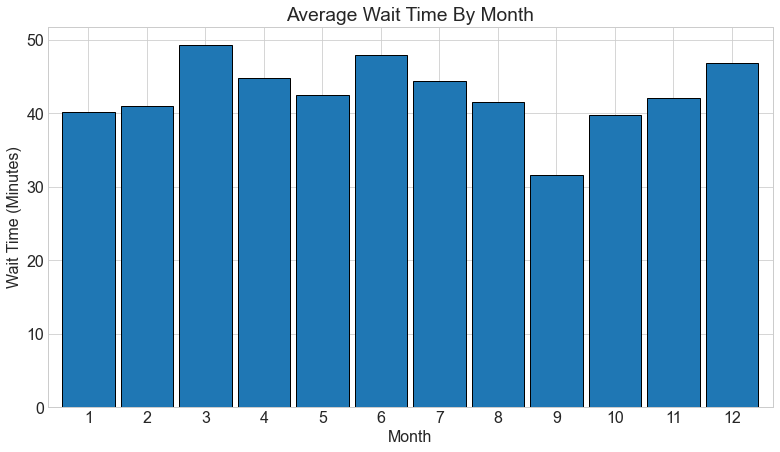

In [31]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Wait Time By Month', xlabel='Month', ylabel='Wait Time (Minutes)')

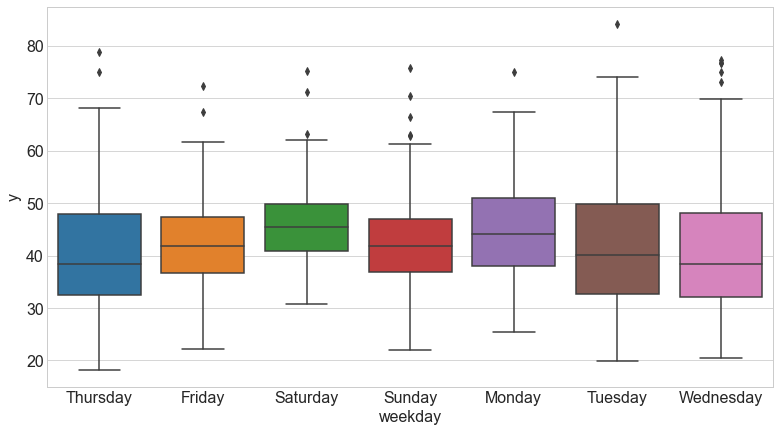

In [32]:
(
    y.reset_index()
    .assign(weekday=lambda df: df.ds.dt.day_name())
    .pipe((sns.boxplot, 'data'), y='y', x='weekday')
)

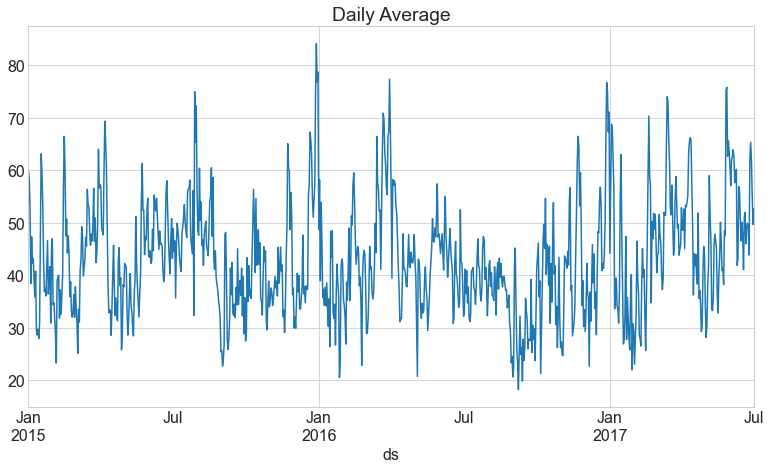

In [33]:
y.resample('D').mean().plot(title='Daily Average')

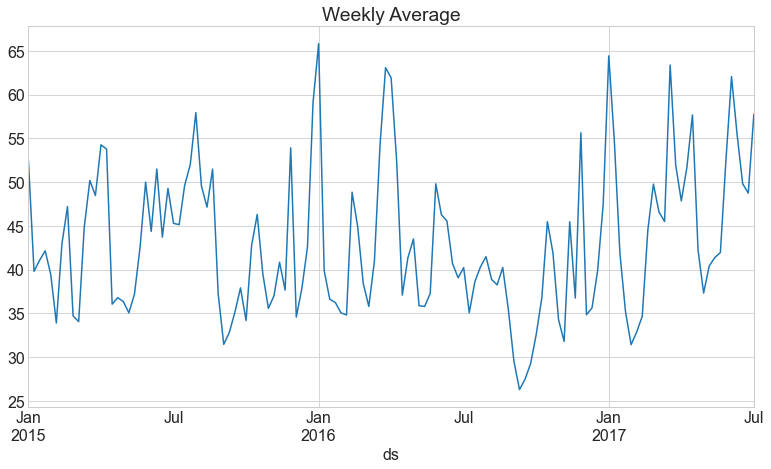

In [34]:
y.resample('W').mean().plot(title='Weekly Average')

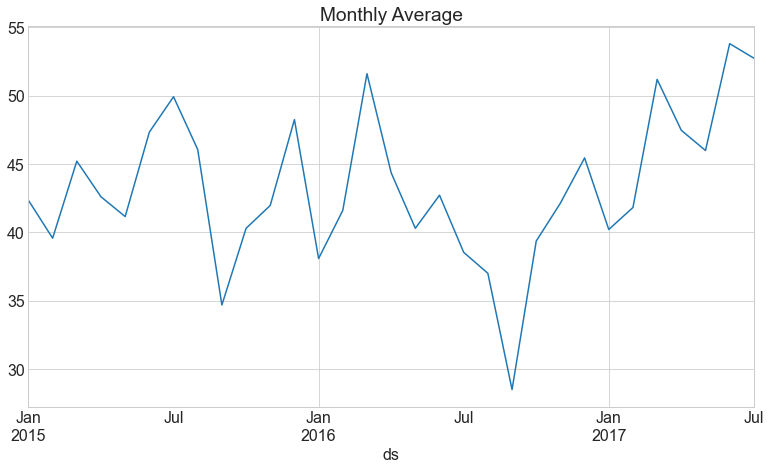

In [35]:
y.resample('M').mean().plot(title='Monthly Average')

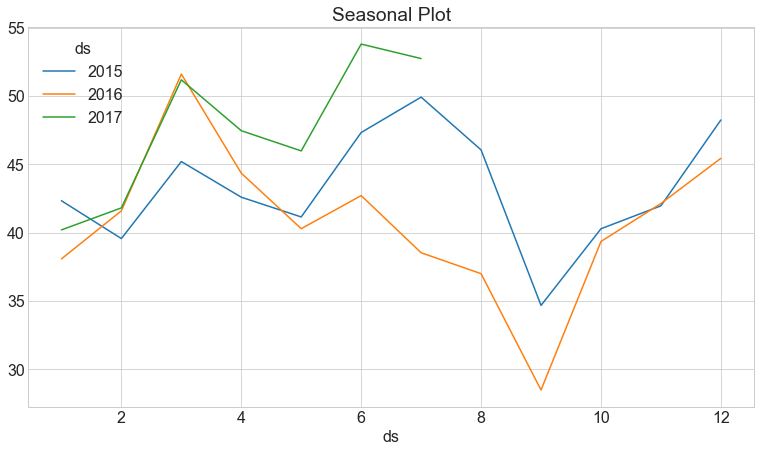

In [36]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

In [37]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [38]:
print(df.head(1) == train.head(1))

               y
ds              
2015-01-01  True


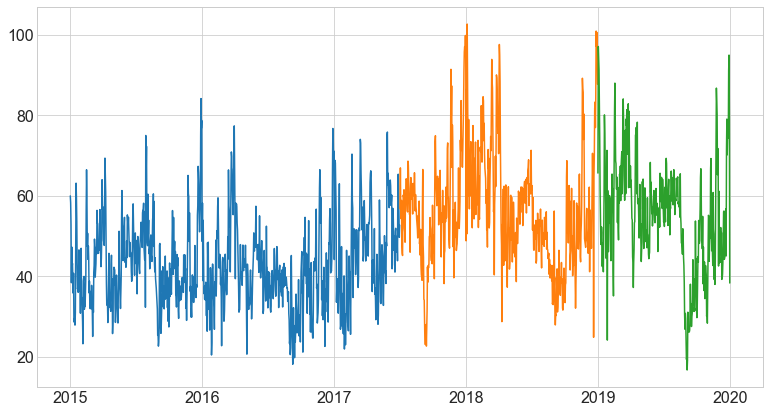

In [39]:
plt.plot(train)
plt.plot(validate)
plt.plot(test)

In [40]:
train['cap'] = 120
train['floor'] = 20

# reset index as prophet needs ds to be a column and not an index. 
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,ds,y,cap,floor
0,2015-01-01,60.00,120,20
1,2015-01-02,58.26,120,20


In [41]:
m = Prophet(daily_seasonality = True,
            weekly_seasonality = True,
            growth = 'logistic',
            changepoint_range = 0.9)
m.add_country_holidays(country_name='US')
m.fit(train)

print(m.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object


In [42]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 120
future['floor'] = 20

In [43]:
pd.concat([future.head(2), future.tail(2)])

,ds,cap,floor
0,2015-01-01,120,20
1,2015-01-02,120,20
1459,2018-12-30,120,20
1460,2018-12-31,120,20


In [44]:
forecast = m.predict(future)

In [45]:
forecast.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (Observed)',
       'Christmas Day (Observed)_lower', 'Christmas Day (Observed)_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (Observed)', 'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
 

In [46]:
forecast[(forecast['Christmas Day'] + 
          forecast['Thanksgiving'] + 
          forecast["New Year's Day"]).abs() > 0]\
        [['ds', 
          'Christmas Day', 
          'Thanksgiving', 
          "New Year's Day"]][-10:]

,ds,Christmas Day,Thanksgiving,New Year's Day
358,2015-12-25,-8.584268,0.000000,0.000000
365,2016-01-01,0.000000,0.000000,-5.612262
693,2016-11-24,0.000000,10.762807,0.000000
724,2016-12-25,-8.584268,0.000000,0.000000
731,2017-01-01,0.000000,0.000000,-5.612262
1057,2017-11-23,0.000000,10.762807,0.000000
1089,2017-12-25,-8.584268,0.000000,0.000000
1096,2018-01-01,0.000000,0.000000,-5.612262
1421,2018-11-22,0.000000,10.762807,0.000000
1454,2018-12-25,-8.584268,0.000000,0.000000


In [47]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2018-12-27,64.254451,54.048804,75.548777
1457,2018-12-28,66.546253,56.568188,77.185372
1458,2018-12-29,70.076225,60.143516,80.186886
1459,2018-12-30,67.250646,56.699787,77.773918
1460,2018-12-31,68.574534,57.415416,79.072615


In [69]:
from sklearn.metrics import mean_squared_error
eval_df = pd.merge(df, forecast[['ds', 'yhat']], how = 'inner', on = 'ds')
eval_df = eval_df.dropna()
rmse = sqrt(mean_squared_error(eval_df.y, eval_df.yhat))
rmse

10.915998152449024

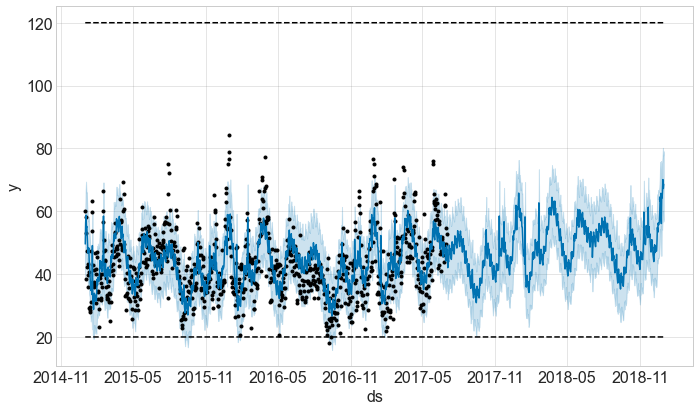

In [70]:
fig1 = m.plot(forecast)

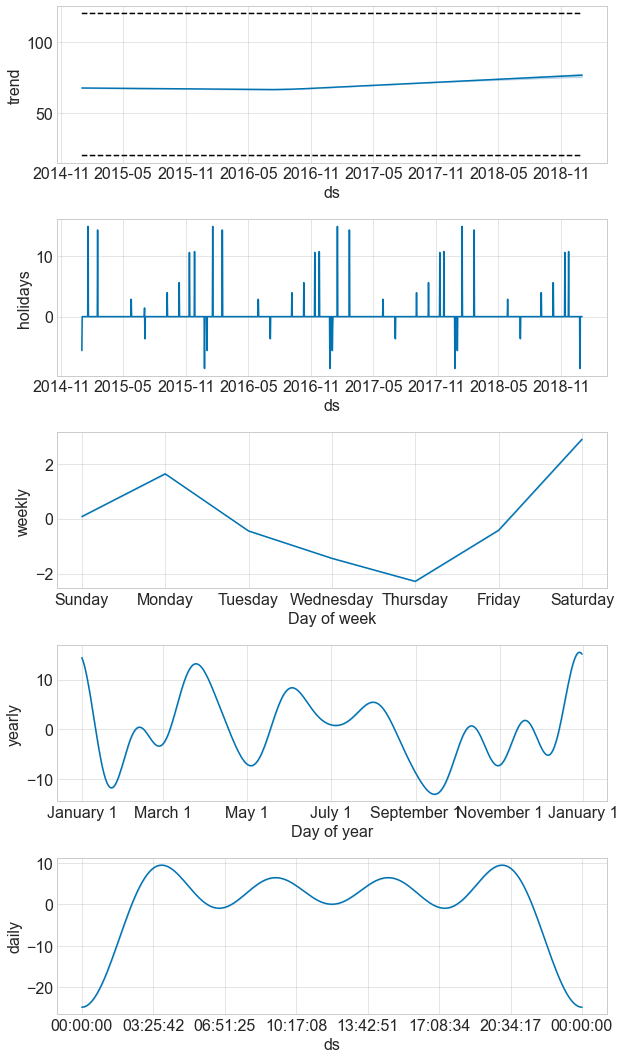

In [71]:
fig2 = m.plot_components(forecast, 'holidays')

In [72]:
df_cv = cross_validation(m, 
                         initial = '730 days', 
                         period = '90 days', 
                         horizon = '180 days', 
                        )
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-01-02 00:00:00 and 2017-01-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-03,52.081723,42.419995,63.154012,68.81,2017-01-02
1,2017-01-04,50.529180,40.691387,60.328415,68.16,2017-01-02
2,2017-01-05,47.527830,37.325783,56.981538,62.45,2017-01-02
3,2017-01-06,47.489640,37.895642,56.917786,56.58,2017-01-02
4,2017-01-07,48.778142,40.133510,57.579365,33.60,2017-01-02


In [73]:
df_cv.cutoff.value_counts()

2017-01-02    180
Name: cutoff, dtype: int64

In [74]:
df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,147.704896,12.153390,9.440073,0.195848,0.168816,0.666667
1,19 days,148.427033,12.183063,9.461412,0.202394,0.168816,0.666667
2,20 days,131.157915,11.452420,8.484210,0.188106,0.159985,0.722222
3,21 days,120.681603,10.985518,7.979607,0.183898,0.159985,0.777778
4,22 days,117.012804,10.817246,7.700912,0.182029,0.147964,0.777778


In [75]:
df_p[df_p.horizon == "60 days"]

,horizon,mse,rmse,mae,mape,mdape,coverage
42,60 days,244.448779,15.634858,13.821345,0.2871,0.314459,0.333333


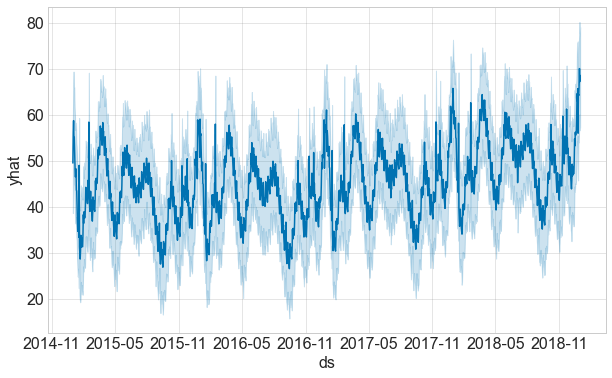

In [76]:
plot_forecast_component(m, forecast, 'yhat')

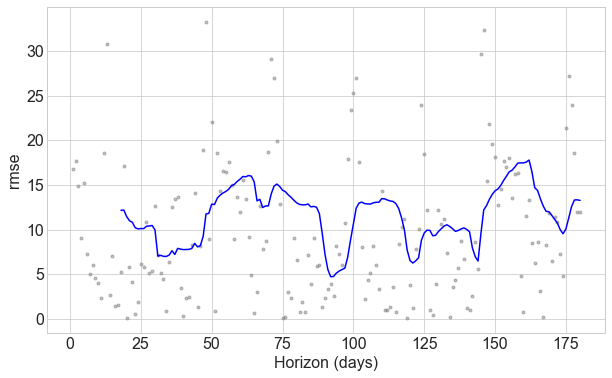

In [77]:
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

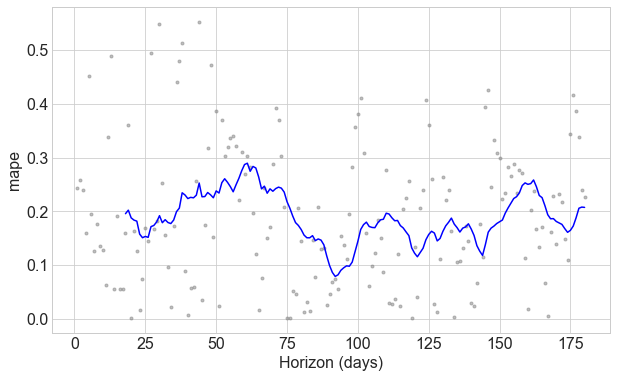

In [78]:
fig3 = plot_cross_validation_metric(df_cv, metric='mape')